In [1]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to calculate Hessian information for a model during training to fit a 1D sinusoidal ODE.
The approach used differs to that used for a 1D exponential ODE, since it stores intermediate values as to ensure
that the calculation does not exceed RAM limitations.
It is designed to work for slightly larger systems (in particular, a NODE with a 7D latent space). For instance, it only calculates the 
Hessian for the MOFD with 1 (carefully made) choice of pertubation parameter.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [2]:
%%capture
%%bash 
pip install torchdiffeq

In [3]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--manual_hessian', action='store_true')
parser.add_argument('--library_hessian', action='store_true')
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.niters = 1500
args.test_freq = 20
args.library_hessian = True
args.manual_hessian = False
args.hessian_freq = 100
args.method = 'dopri5'
args.data_size = 50

In [13]:
#The technique only works when the adjoint method is not used. If it is used, the Hessian returned is a matrix of zeros.
adjoint = False

if adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
if adjoint == False:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

true_y0 = torch.tensor([[2., 1.]]).to(device)
t = torch.linspace(0., 7., args.data_size).to(device)
f = 1.0
true_A = torch.tensor([[0.0, f], [-f, -0.0]]).to(device)

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)

#The true solution defines two sinusoidal curves.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method = args.method)

In [6]:
class ODEFunc(nn.Module):
    """
    Defines a very simple neural net.
    """

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.Softplus(),
            nn.Linear(8, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [7]:
class Network(nn.Module):
  """
  Neural network that is used for Hessian calculation with library-function and MOFD approaches.
  The parameter groups are chosen to match those of ODEFunc().
  """

  def __init__(self, a, b, c, d):
    super(Network, self).__init__()
    self.a = a
    self.b = b
    self.c = c
    self.d = d

  def forward(self, t, y):
    x = F.linear(y, self.a, self.b)
    m = nn.Softplus()
    x = m(x)
    x = F.linear(x, self.c, self.d)
    return x

In [8]:
def get_loss(params_vector):

  a = params_vector[:16].reshape([8, 2])
  b = params_vector[16:24].reshape([8])
  c = params_vector[24:40].reshape([2, 8])
  d = params_vector[40:42].reshape([2])
  
  neural_net = Network(a, b, c, d).to(device)
  pred_y = odeint(neural_net, true_y0, t, method= args.method)
  loss_func = nn.MSELoss()
  loss = loss_func(pred_y, true_y)
  return loss

def get_library_hessian(net):
  """
  Obtains the Hessian of the NODE using the autograd.functional.hessian() function.
  Inputs: 
        - net: the network for which the Hessian is to be calculated.
  NB: Each individual NODE architecture must be specified in the function get_loss(), such that
  the Hessian is calculated correctly.
  """

  param_tensors = net.parameters()
  params_vector = torch.tensor([]).to(device)
  for param in param_tensors:
    vec = torch.reshape(param, (-1,)).to(device)
    params_vector = torch.cat((params_vector, vec))

  hessian = torch.autograd.functional.hessian(get_loss, params_vector)
  return hessian

In [9]:
def get_manual_hessian(grads, parameters, show_iters=True):
  """
  Calculation of the Hessian using nested for loops.
  Inputs:   - grads:        tuple of gradient tensors. Created using something 
                            like grads = torch.autograd.grad(loss, parameters, create_graph=True).
            - parameters:   List of parameter objects. Created using something 
                            like parameters = optimizer.param_groups[0]['params'].
            - show_iters:   True or False, depending on if the iteration number is to be shown during training. 
                            Note that the iteration updates are not provided every row, but instead periodically 
                            (roughly according to the number of parameters in the system).
  """
  start = time.time()        

  n_params = 0
  for param in parameters:
    n_params += torch.numel(param)
  grads2 = torch.zeros(n_params,n_params)            #Create an matrix of zeros thas has the same shape as the Hessian.

  y_counter = 0                             #y_direction refers to row number in the Hessian.

  for grad in grads:
      grad = torch.reshape(grad, [-1])                                  #Rearrange the gradient information into a vector.        

      for j, g in enumerate(grad):
        x_counter = 0                                                   #x_direction refers to column number in the Hessian.

        for l, param in enumerate(parameters):
          g2 = torch.autograd.grad(g, param, retain_graph=True)[0]      #Calculate the gradient of an element of the gradient wrt one layer's parameters.
          g2 = torch.reshape(g2, [-1])                                  #Reshape this into a vector.
          len = g2.shape[0]                       
          grads2[j+y_counter, x_counter:x_counter+len] = g2             #Indexing ensures that the second order derivatives are placed in the correct positions.
          x_counter += len

      grads2 = grads2.to(device)
      y_counter += grad.shape[0]

      if show_iters:
        print("Gradients calculated for row number " + str(y_counter) + ".")
  
  print('Time used was ', time.time() - start)

  return grads2

In [21]:
def get_mofd_hessian_element(p_vec, shapes, base_loss, i, k, h=1e-4):
  """
  Calculates an individual element of the Hessian via the MOFD.
  Inputs: - p_vec:        the parameters of the network organized into a vector.
          - shapes:       a list of torch.Size() objects describing the shapes of each parameter group.
          - base_loss:    loss of the unperturbed system. Used in calculating diagonal Hessian elements.
          - h:            the size of the pertubation applied to each parameter.
          - i and k:      the indices of the element to be calculated.
          - show_iters:   True or False according to whether iteration number is to be displayed during calculation.

  Returns: - 'grad2':     torch.tensor() object containing the Hessian element H[i,k] = H[k,i].
  
  NB: This function adapts to network architecture automatically.
  The code is designed to convert all floats to 64-bit automatically.
  """
  loss_func = nn.MSELoss()

  #List of integers detailing the number of elements in each parameter group.
  nels = [int(torch.prod(torch.tensor(shape))) for shape in shapes]
  nels = torch.tensor(nels)
  nels = torch.cumsum(nels, dim=0)
  nels = nels.tolist()

  #Empty tensors to store mofd info and perturbed parameters.
  up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_pert_p_vec = torch.zeros_like(p_vec).double()

  up_up_pert_p_vec = torch.zeros_like(p_vec).double()
  up_low_pert_p_vec = torch.zeros_like(p_vec).double()
  low_up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_low_pert_p_vec = torch.zeros_like(p_vec).double()
    
  #Versions of the parameter vector to be perturbed.
  for j in range(len(p_vec)):
    up_pert_p_vec[j] = p_vec[j]
    low_pert_p_vec[j] = p_vec[j]
    
  #Calculate the diagonal elements.
  if k == i:
    up_pert_p_vec[k] += h
    low_pert_p_vec[k] -= h

    a_up = up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up = up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up = up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up = up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    a_low = low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low = low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low = low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low = low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    neural_net_up = Network(a_up, b_up, c_up, d_up).to(device)
    pred_y_up = odeint(neural_net_up, true_y0.double(), t.double(), method=args.method)
    pert_loss_up = loss_func(pred_y_up, true_y.double()).double()

    neural_net_low = Network(a_low, b_low, c_low, d_low).to(device)
    pred_y_low = odeint(neural_net_low, true_y0.double(), t.double(), method=args.method)
    pert_loss_low = loss_func(pred_y_low, true_y.double()).double()
    
    grad2 = ((pert_loss_up - 2*base_loss + pert_loss_low)/(h**2)).double()

  #Calculate the off-diagonal elements.
  if k > i:
    
    #Vectors to be perturbed (there are 4 of these).
    #They must be created individually for each k so that previous iterations do not affect the parameter values.
    for l in range(len(p_vec)):
      up_up_pert_p_vec[l] = p_vec[l]
      up_low_pert_p_vec[l] = p_vec[l]
      low_up_pert_p_vec[l] = p_vec[l]
      low_low_pert_p_vec[l] = p_vec[l]

    up_up_pert_p_vec[i] += h
    up_up_pert_p_vec[k] += h

    up_low_pert_p_vec[i] += h
    up_low_pert_p_vec[k] -= h

    low_up_pert_p_vec[i] -= h
    low_up_pert_p_vec[k] += h

    low_low_pert_p_vec[i] -= h
    low_low_pert_p_vec[k] -= h

    a_up_up = up_up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up_up = up_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up_up = up_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up_up = up_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    a_up_low = up_low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up_low = up_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up_low = up_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up_low = up_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    a_low_up = low_up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low_up = low_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low_up = low_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low_up = low_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    a_low_low = low_low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low_low = low_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low_low = low_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low_low = low_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])

    neural_net_up_up = Network(a_up_up, b_up_up, c_up_up, d_up_up).to(device)
    pred_y_up_up = odeint(neural_net_up_up, true_y0.double(), t.double(), method=args.method)
    pert_loss_up_up = loss_func(pred_y_up_up, true_y.double()).double()

    neural_net_up_low = Network(a_up_low, b_up_low, c_up_low, d_up_low).to(device)
    pred_y_up_low = odeint(neural_net_up_low, true_y0.double(), t.double(), method=args.method)
    pert_loss_up_low = loss_func(pred_y_up_low, true_y.double()).double()

    neural_net_low_up = Network(a_low_up, b_low_up, c_low_up, d_low_up).to(device)
    pred_y_low_up = odeint(neural_net_low_up, true_y0.double(), t.double(), method=args.method)
    pert_loss_low_up = loss_func(pred_y_low_up, true_y.double()).double()

    neural_net_low_low = Network(a_low_low, b_low_low, c_low_low, d_low_low).to(device)
    pred_y_low_low = odeint(neural_net_low_low, true_y0.double(), t.double(), method=args.method)
    pert_loss_low_low = loss_func(pred_y_low_low, true_y.double()).double()
    
    #MOFD formula to estimate second order gradient.
    grad2 = ((pert_loss_up_up - pert_loss_up_low - pert_loss_low_up + pert_loss_low_low)/(4*h**2)).double()

  return grad2

In [11]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------
The following code is used for Hessian analysis.
-----------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [ ]:
#Calculate the Hessian for all saved models during training.
#The models were saved with different test frequencies at different stages. The analysis below reflects this.

library_hessian_data = [] 

#################################################################################

itr = 1

model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                  + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                  + '/20_dims/models/model_' + str(itr) + '.pt', 
                   map_location=device)

model = model.to(device)

print('Obtaining library hessian for iteration ' + str(itr) + '...')
library_start = time.time()
library_hessian = get_library_hessian(model)                       #get hessian with library functions   
library_end = time.time()
print("Time taken was " + str(round(library_end-library_start,2)) + "s.")

library_hessian_data.append((itr, library_end-library_start, library_hessian))

#################################################################################

for itr in range(20, 1520, 20):

  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                    + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                    + '/20_dims/models/model_' + str(itr) + '.pt', 
                    map_location=device)

  model = model.to(device)

  print('Obtaining library hessian for iteration ' + str(itr) + '...')
  library_start = time.time()
  library_hessian = get_library_hessian(model)                       #get hessian with library functions   
  library_end = time.time()
  print("Time taken was " + str(round(library_end-library_start,2)) + "s.")

  library_hessian_data.append((itr, library_end-library_start, library_hessian))

torch.save(library_hessian_data,  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                                  + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                                  + '/20_dims/hessian_data/library_hessian_data.pt')

Obtaining library hessian for iteration 1...
Time taken was 6.83s.
Obtaining library hessian for iteration 20...
Time taken was 7.56s.
Obtaining library hessian for iteration 40...
Time taken was 6.61s.
Obtaining library hessian for iteration 60...
Time taken was 6.59s.
Obtaining library hessian for iteration 80...
Time taken was 5.91s.
Obtaining library hessian for iteration 100...
Time taken was 6.78s.
Obtaining library hessian for iteration 120...
Time taken was 7.46s.
Obtaining library hessian for iteration 140...
Time taken was 8.86s.
Obtaining library hessian for iteration 160...
Time taken was 9.01s.
Obtaining library hessian for iteration 180...
Time taken was 8.42s.
Obtaining library hessian for iteration 200...
Time taken was 9.07s.
Obtaining library hessian for iteration 220...
Time taken was 11.04s.
Obtaining library hessian for iteration 240...
Time taken was 11.57s.
Obtaining library hessian for iteration 260...
Time taken was 8.56s.
Obtaining library hessian for iteratio

In [ ]:
for item in library_hessian_data:
  e, v = torch.symeig(item[2])
  plt.hist(e, bins = 150)
  plt.title('Iterations: ' + str(item[0]))
  plt.xlabel('Eigenvalue')
  plt.ylabel('Density')
  plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                    + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                    + '/20_dims/eigenvalue_density_plots/eigenvalue_density_'
                    + str(item[0]) + '.pdf')
  plt.show()

In [ ]:
itr = 1

for item in library_hessian_data:
  if item[0] == itr:
    library_hessian = item[2]

Obtaining manual hessian...
Gradients calculated for row number 16.
Gradients calculated for row number 24.
Gradients calculated for row number 40.
Gradients calculated for row number 42.
Time used was  6.1869118213653564


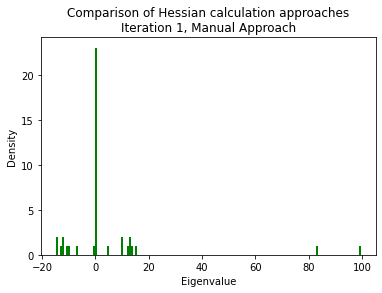

In [20]:
#Get manual Hessian for a given iteration.

itr = 1

model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                    + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                    + '/08_dims/models/model_' + str(itr) + '.pt', 
                    map_location=device)

optimizer = optim.RMSprop(model.parameters())
optimizer.zero_grad()

pred_y = odeint(model, true_y0, t, method=args.method)
base_loss_func = nn.MSELoss()
base_loss = base_loss_func(pred_y, true_y)
grads = torch.autograd.grad(base_loss, model.parameters(), create_graph=True)
parameters = optimizer.param_groups[0]['params']

print('Obtaining manual hessian...')
manual_hessian = get_manual_hessian(grads, parameters)           #get manual hessian.

#torch.save(manual_hessian, '/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/'
                        #+ 'sinusoidal_curve/more_developed_system/experiments/hessian_data/'
                        #+ str(itr) + '_manual_hessian.pt')

e_ma, v_ma = torch.symeig(manual_hessian)
plt.hist(e_ma.cpu().detach().numpy(), bins=150, color = 'Green')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', Manual Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.show()

In [28]:
#Get MOFD Hessian for a given model.

itr = 120

model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                    + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                    + '/08_dims/models/model_' + str(itr) + '.pt', 
                    map_location=device)
model = model.to(device)

double_model = model.double()
optimizer = optim.RMSprop(model.parameters())
optimizer.zero_grad()

#Prepare loss for MOFD.
pred_y = odeint(double_model, true_y0.double(), t.double(), method=args.method).double()
base_loss_func = nn.MSELoss()
base_loss = base_loss_func(pred_y, true_y.double())

#Prepare shape information for MOFD.
shapes = []
for param in model.parameters():
  shapes.append(param.shape)

#Create vector of parameters.
param_tensors = double_model.parameters()
params_vec = torch.tensor([]).to(device)
for param in param_tensors:
  vec = torch.reshape(param, (-1,)).to(device)
  params_vec = torch.cat((params_vec, vec))

w = len(params_vec)
print('Getting Hessian with h = 1e-4')
counter = w*(w+1)/2
mofd_hessian = torch.zeros((w,w)).double()
for i in range(len(params_vec)):
  for k in range(len(params_vec)):

    #Only calculate for k >= i, in the same way as get_mofd_hessian_element().
    #Failing to do so yields UnboundLocalError since local variable, grad2, is referenced before assignment.
    if k >= i:                     
      element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-4)
      mofd_hessian[i,k] = element.item()    #.item() is required to prevent RAM growth.
      mofd_hessian[k,i] = element.item()
      counter -= 1
      print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

#torch.save(mofd_hessian, '/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/'
                        #+ 'sinusoidal_curve/more_developed_system/experiments/hessian_data/'
                        #+ str(itr) + '_mofd_hessian_7.pt')

Getting Hessian with h = 1e-7
Iterations remaining: 0, Element: 13.67443429600712


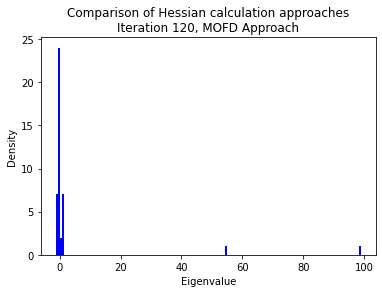

In [29]:
e_mo, v_mo = torch.symeig(mofd_hessian)
plt.hist(e_mo.cpu().detach().numpy(), bins=150, color = 'Blue')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', MOFD Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.show()

In [ ]:
e_l, v_l = torch.symeig(library_hessian)
plt.hist(e_l.cpu().detach().numpy(), bins=150, color = 'Orange')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', Library Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/sinusoidal_curve'
            + '/more_developed_system/experiments/eigenvalue_density_plots_comparisons/' + str(itr)
            + '_lib_eigenvalue_density.png')
plt.show()

e_ma, v_ma = torch.symeig(manual_hessian)
plt.hist(e_ma.cpu().detach().numpy(), bins=150, color = 'Green')
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', Manual Approach')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/sinusoidal_curve'
            + '/more_developed_system/experiments/eigenvalue_density_plots_comparisons/' + str(itr)
            + '_man_eigenvalue_density.png')
plt.show()

h = 1e-7
e_mo, v_mo = torch.symeig(mofd_hessian)
plt.hist(e_mo.cpu().detach().numpy(), bins=150)
plt.title('Comparison of Hessian calculation approaches\nIteration ' + str(itr) + ', MOFD, h = ' + str(h))
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_simple_nodes/sinusoidal_curve'
            + '/more_developed_system/experiments/eigenvalue_density_plots_comparisons/' + str(itr)
            + '_mofd_7_eigenvalue_density.png')
plt.show()